I want to show how memory consumption scales with subsetting the image, both on the spatial level and on the marker level.
X axis should show spatial subset size, y axis should show memory, lineplot where hue is number of markers (do 1, 5, 10, 20, and 53).

In [6]:
import os
import time
import tracemalloc
from glob import glob
import xarray as xr
import tifffile
import spatialproteomics as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gc
from tqdm.auto import tqdm

channel_options_numeric = [1, 5, 10, 20, 53]
#channel_options_numeric = [10]
channels = list(pd.read_csv('/g/huber/projects/CITEseq/CODEX/RICOVER60/whole_tissue_slides_tiffs/MarkerList.txt', header=None)[0])
channel_options_string = [channels[:x] if x is not None else channels for x in channel_options_numeric]

#subset_options = [500, 1000, 2000, 5000, 10000, 20000, None]
subset_options = [None]

sample_ids = glob('/g/huber/projects/CITEseq/CODEX/RICOVER60/whole_tissue_slides_tiffs/tiffs/*.qptiff')
sample_ids = [x.split("/")[-1].replace(".qptiff", "") for x in sample_ids]

In [2]:
results = []

def benchmark_read_zarr(path, channels=None, spatial_subset=None, trigger_read=True):
    """Read Zarr file with optional channel + spatial subsetting."""
    tracemalloc.start()
    start = time.perf_counter()

    # read file
    ds = xr.open_zarr(path)
    # before subsetting, this is the size of the image
    image_size_bytes = ds['_image'].size / 1e6
    
    # subset file
    if channels is not None:
        if spatial_subset is None:
            ds = ds.pp[channels]
        else:
            ds = ds.pp[channels, 0:spatial_subset, 0:spatial_subset]
    elif spatial_subset is not None:
        ds = ds.pp[0:spatial_subset, 0:spatial_subset]
        
    image_size_spatial = ds['_image'].sizes['x'] * ds['_image'].sizes['y']
        
    if trigger_read:
        ds = ds["_image"].values  # trigger actual read

    end = time.perf_counter()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return end - start, peak / 1e6, image_size_bytes, image_size_spatial  # runtime (s), memory (MB), img

In [3]:
for sample_id in tqdm(sample_ids):
    # memory baseline for reading the full tiff file
    zarr_file = f'/g/huber/projects/CITEseq/CODEX/RICOVER60/whole_tissue_slides_tiffs/spatprot_outputs/zarrs/{sample_id}.zarr'

    for ch in tqdm(channel_options_string):
        for subset in subset_options:
            runtime, mem, size_bytes, size_spatial = benchmark_read_zarr(zarr_file, channels=ch, spatial_subset=subset, trigger_read=True)
            results.append({
                "format": "zarr_compute",
                "method": "compute",
                "subset": size_spatial,  # now correct for full image
                "channels": len(ch),
                "runtime_s": runtime,
                "memory_mb": mem,
                "img_bytes": size_bytes,
                "sample_id": sample_id
            })
            gc.collect()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# --- Results DataFrame ---
df = pd.DataFrame(results)
df.to_csv("results/wsis/benchmark_results.csv", index=False)

In [32]:
import matplotlib as mpl

mpl.style.core.use('/g/huber/users/meyerben/notebooks/spatialproteomics_pipelines/spatialproteomics_bnhl/figures/pub_matplotlib_rc.ini')
font_size = 6.5
point_size = 20
point_border_color = '#49566d'  # dark gray
line_width = 0.6

# Set global font size
plt.rcParams.update({"font.size": font_size})  # Adjust the value as needed

# --- Global style ---
mpl.rcParams.update({
    "font.size": font_size,        # for labels, ticks, legends
    "axes.labelsize": font_size,   # axis labels
    "xtick.labelsize": font_size,  # x tick labels
    "ytick.labelsize": font_size,  # y tick labels
    "legend.fontsize": font_size,  # legend text
    "lines.linewidth": line_width, # default line width
    "axes.linewidth": line_width,  # axes border width
    "grid.linewidth": line_width   # grid lines
})

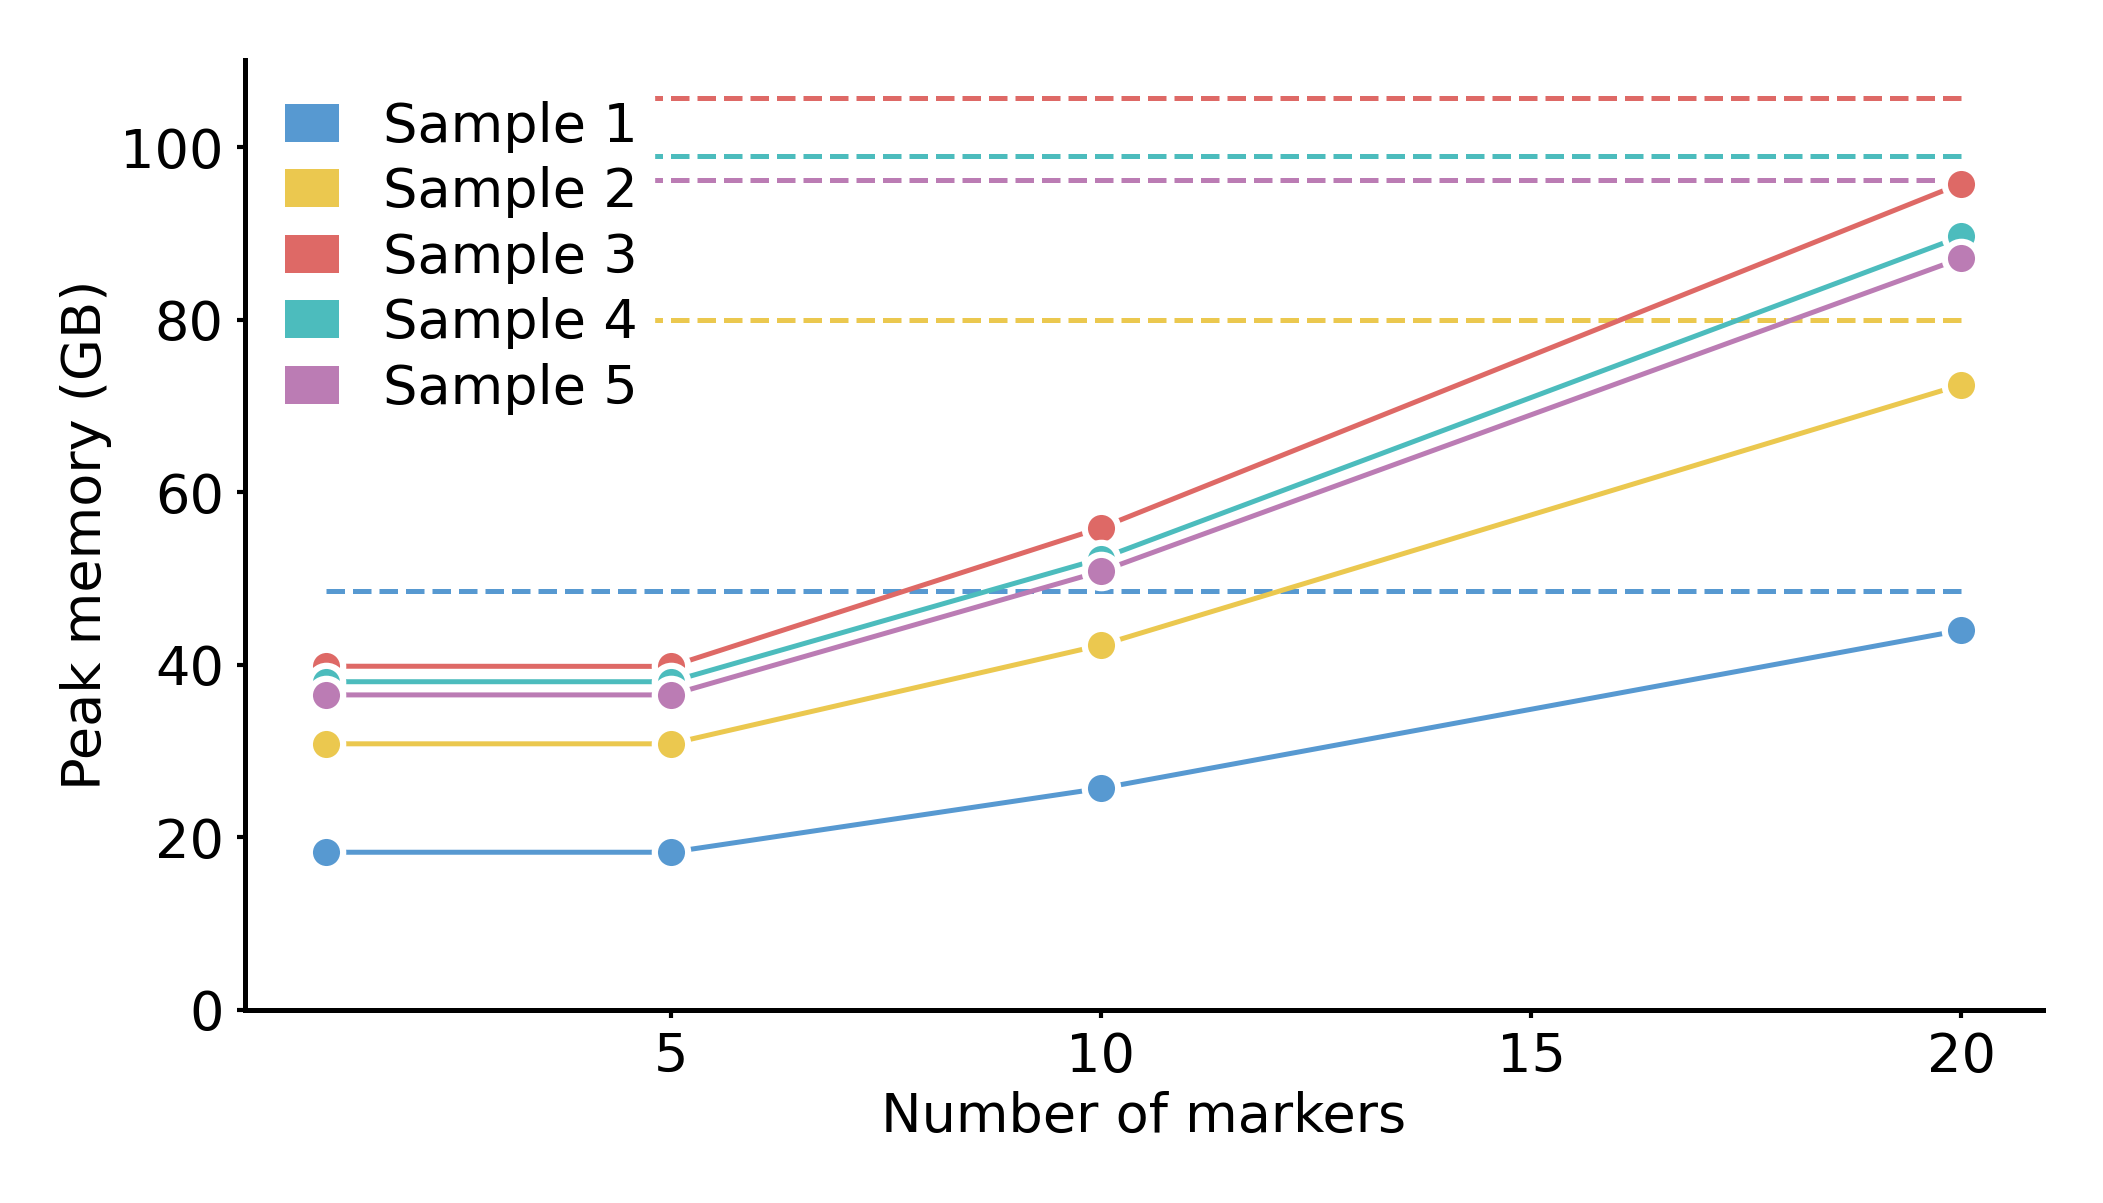

In [48]:
from matplotlib.patches import Patch

df_tmp = df.copy() 
df_tmp['memory_gb'] = df_tmp['memory_mb'] / 1000 
df_tmp = df_tmp[df_tmp['channels'] < 53] 
df_tmp['sample_id'] = [id_dict.get(x) for x in df_tmp['sample_id'].values] 
colors = dict(zip(df_tmp['sample_id'].unique(), ['#de6966', '#5799d1', '#ebc84f', '#4cbcbd', '#bb7cb4']))

fig, ax = plt.subplots(figsize=(3.5, 2), dpi=600)

# --- Baseline lines ---
for sample_id, color in colors.items():
    mem_baseline = df_tmp[df_tmp['sample_id'] == sample_id]['img_bytes'].mean() / 1000
    ax.hlines(mem_baseline, xmin=1, xmax=20, linestyles='dashed', color=color)

# --- Lineplot ---
sns.lineplot(
    data=df_tmp,
    x='channels',
    y='memory_gb',
    hue='sample_id',
    palette=colors,
    marker='o',
    linewidth=line_width,
    markersize=4,
    ax=ax
)

# --- Legend ---
handles, labels = ax.get_legend_handles_labels()
order = np.argsort(labels)  # alphabetical order

# Replace line handles with colored rectangles
rect_handles = [
    Patch(facecolor=colors[labels[i]], label=labels[i])
    for i in order
]

ax.legend(
    rect_handles,
    [labels[i] for i in order],
    title=None,
    frameon=True,
    facecolor="white",
    edgecolor="white",
    framealpha=1,
    fontsize=font_size
)

# --- Style ---
sns.despine()
ax.set_xlabel("Number of markers")
ax.set_ylabel("Peak memory (GB)")
ax.set_ylim(0)
ax.set_xticks([5, 10, 15, 20])  # custom xticks

plt.tight_layout()
plt.savefig('figs/supp_fig_7b.svg', bbox_inches='tight', pad_inches=0)
plt.show()